In [1]:
import time
import copy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

## Read data

In [2]:
import pickle
# import xgboost
# import s3fs

In [3]:
# # Save model to bucket
# s3 = s3fs.S3FileSystem(anon=False, 
#                        key='',
#                        secret='')
# # Use 'w' for py3, 'wb' for py2
# with s3.open('bsa-correlation-one/models/xgboost_cellphones_C.pkl','rb') as f:
#     # END
#     model = pickle.load(f)

In [4]:
with open('./lr_cellphone_C.pkl','rb') as f:
    # END
    model = pickle.load(f)


# with open('./scalerX_cellphone_C.pkl','rb') as f:
#     # END
#     scaler_x = pickle.load(f)
    
    
# with open('./scalerY_cellphone_C.pkl','rb') as f:
#     # END
#     scaler_y = pickle.load(f)

/home/renato/.pyenv/versions/miniconda3-4.3.30/envs/main/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/renato/.pyenv/versions/miniconda3-4.3.30/envs/main/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LinearRegression from version 0.21.3 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [5]:
def base_cost(offer):
    return 0.8 * offer

In [6]:
data = pd.read_csv('./cellphones/cellphonedata.csv')

df = data[data.price_category == 'C'].copy().reset_index(drop=True)
# df.drop(columns = ['ds','price_category','y','offer'],inplace=True)
df.drop(columns = ['ds','price_category','y'],inplace=True)

cols = df.columns
#array = scaler_x.transform(df)
#df = pd.DataFrame(array,columns=cols)
df['base_cost'] = df.offer.apply(lambda x: base_cost(x))
df.drop(columns=['olist_price','offer'], inplace = True)

df.tail()

,year,month,dayofweek,day,freight_value,competition_price,stock,black_friday,carnival,christmas,friday,mothers_day,new_year,others,valentines,base_cost
971,2020,2,0,24,26.165168,982.949133,7563.0,0,1,0,0,0,0,0,0,747.528000
972,2020,2,1,25,26.522039,988.725646,7557.0,0,1,0,0,0,0,0,0,751.569143
973,2020,2,2,26,24.607285,994.662702,7545.0,0,0,0,0,0,0,0,0,747.531678
974,2020,2,3,27,22.893772,1007.349470,7454.0,0,0,0,0,0,0,0,0,743.240006
975,2020,2,4,28,31.916422,1095.717500,127.0,0,0,0,0,0,0,0,0,749.329333


### Demand Simulator

In [7]:
def predict_demand(model, df_row, olist_price):
    
    year = df_row.year
    month = df_row.month
    dayofweek = df_row.dayofweek
    day = df_row.day
    olist_price = olist_price
    freight_value = df_row.freight_value
    competition_price = df_row.competition_price
    stock = df_row.stock
    black_friday = df_row.black_friday
    carnival = df_row.carnival
    christmas = df_row.christmas
    friday = df_row.friday
    mothers_day = df_row.mothers_day
    new_year = df_row.new_year
    others = df_row.others
    valentines = df_row.valentines

    X = np.array([year, month, dayofweek, day, olist_price, freight_value,
                 competition_price, stock, black_friday, carnival, christmas,
                 friday, mothers_day, new_year, others, valentines]).reshape(1,-1)
    
    #X = xgboost.DMatrix(X)
                 
    orders = model.predict(X)
    
    return max(orders[0],0)

In [8]:
predict_demand(model, df.iloc[-1], 945)

7.517765366013464

In [9]:
df.iloc[0].year

2017.0

### Environment Real Data

In [10]:
class Environment:
    
    def __init__(self, model, df):
        
        self.model = model
        self.data = df
        self.N = len(self.data) - 1
        # want to obtain
        # self.olist_price = 0
        # self.freight_value = 0
        
        self.reset()
        
#         #try loading row
#         self.year = year
#         self.month = month
#         self.dayofweek = dayofweek
#         self.day = day
#         self.competition_price = competition_price
#         self.stock = stock
#         self.black_friday = black_friday
#         self.carnival = carnival
#         self.christmas = christmas
#         self.friday = friday
#         self.mothers_day = mothers_day
#         self.new_year = new_year
#         self.others = others
#         self.valentines = valentines
#         self.base_cost = base_cost
        
        # self.price_init = cost/0.8
        
        
        
        
    def reset(self):
        self.t = 0
        self.done = False
        #self.demand_h = [0 for _ in range(self.demand_t)]
        #self.competitor_h = [0 for _ in range(self.competitor_t)]
        self.orders = 0
        self.olist_price = 0
        self.profits = 0
        return [self.olist_price, self.orders] + self.data.iloc[self.t].tolist() 
    
    def step(self, act):       
        
        # act = 0: stay, 1: raise, 2: lower
        if act == 0:
            self.olist_price = self.data['base_cost'][self.t] * 1.05
        elif act == 1:
            self.olist_price = self.data['base_cost'][self.t] * 1.10
        elif act == 2:
            self.olist_price = self.data['base_cost'][self.t] * 1.15
        elif act == 3:
            self.olist_price = self.data['base_cost'][self.t] * 1.20
        elif act == 4:
            self.olist_price = self.data['base_cost'][self.t] * 1.25

        # Calculate demand
        self.orders = predict_demand(self.model, self.data.iloc[self.t], self.olist_price)        

        reward = (self.olist_price + self.data['freight_value'][self.t] - self.data['base_cost'][self.t])*self.orders
        self.profits += reward

        # set next time
        self.t += 1
        
        if (self.t == self.N):
            self.done=True

        return [self.olist_price, self.orders] + self.data.iloc[self.t].tolist(), reward, self.done # obs, reward, done 

In [11]:
env1 = Environment(model,df)
env1.reset()

[0,
 0,
 2017.0,
 6.0,
 4.0,
 30.0,
 25.73,
 931.1842857142856,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 744.9474285714285]

## NN architecture

In [20]:
#def train_dqn(env):

#whats the return?
class Q_Network(nn.Module):
        
    def __init__(self,obs_len,hidden_size,actions_n):
            
        super(Q_Network,self).__init__()
            
        self.fc_val = nn.Sequential(
            nn.BatchNorm1d(num_features=obs_len),
            nn.Linear(obs_len, hidden_size),            
            nn.ReLU(),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Linear(hidden_size, actions_n),
            
            # needs softmax?
        )
        
        
    def forward(self,x):
        h =  self.fc_val(x)
        return (h)
            

## Parameters

In [42]:
env = Environment(model,df)
env.reset()

hidden_size = 100 #100
input_size = 2 + df.shape[1]
output_size = 5
LR = 0.001

epoch_num = 4
step_max = len(env.data) - 1
memory_size = 1000
batch_size = 50
gamma = 0.97

epsilon = 1.0
epsilon_decrease = 1e-3
epsilon_min = 0.1
start_reduce_epsilon = 200
train_freq = 50
update_q_freq = 20
show_log_freq = 5

## Training

In [47]:
memory = []
total_step = 0
total_rewards = []
total_losses = []

device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

Q = Q_Network(input_size, hidden_size, output_size).to(device=device)

Q_ast = copy.deepcopy(Q)

loss_function = nn.MSELoss()
optimizer = optim.Adam(list(Q.parameters()), lr=LR)

start = time.time()
for epoch in range(epoch_num):

    pobs = env.reset()
    step = 0
    done = False
    total_reward = 0
    total_loss = 0

    while not done and step < step_max:

        # select act

        pact = np.random.randint(5)
        if np.random.rand() > epsilon:
            #whats the return value?
            Q.eval()
            pact = Q(torch.from_numpy(np.array(pobs, dtype=np.float32).reshape(1, -1)).to(device=device))
            pact = np.argmax(pact.data.cpu())
            pact = pact.numpy()
        
        # act
        obs, reward, done = env.step(pact)

        # add memory
        
        memory.append((pobs, pact, reward, obs, done))
        if len(memory) > memory_size:
            memory.pop(0)

        # train or update q
        if len(memory) == memory_size:
            if total_step % train_freq == 0:                
                memory_a = np.array(memory)
                train_data_length = len(memory_a)
                t_pobs = np.array(memory_a[:, 0].tolist(), dtype=np.float32)
                t_pact = np.array(memory_a[:, 1].tolist(), dtype=np.int32)
                t_reward = np.array(memory_a[:, 2].tolist(), dtype=np.int32)
                t_obs = np.array(memory_a[:, 3].tolist(), dtype=np.float32)
                t_done = np.array(memory_a[:, 4].tolist(), dtype=np.bool)

                Q.train()
                q_ = Q_ast(torch.from_numpy(t_obs).to(device=device))
                q_full = Q(torch.from_numpy(t_pobs).to(device=device))
                
                maxq = np.max(q_.data.cpu().numpy(), axis=1)
                t_target = copy.deepcopy(q_full.data)
                
                for j in range(train_data_length):
                    t_target[j, t_pact[j]] = t_reward[j]+gamma*maxq[j]*(not t_done[j])               

                
                train_set = [
                    (t_pobs[i], t_target[i]) for i in range(train_data_length)
                ]
                
                train_loader = torch.utils.data.DataLoader(
                    train_set, batch_size=batch_size, shuffle=True
                )
                
                #import pdb; pdb.set_trace()
                
                for i, (b_pobs, target) in enumerate(train_loader):                    
                    q = Q(b_pobs.to(device=device))                    
                    Q.zero_grad()
                    loss = loss_function(q, target)
                    total_loss += loss.data.item()
                    loss.backward()
                    optimizer.step()
                    
            if total_step % update_q_freq == 0:                
                Q_ast = copy.deepcopy(Q)
                
            # epsilon
            if epsilon > epsilon_min and total_step > start_reduce_epsilon:
                epsilon -= epsilon_decrease

            # next step
            total_reward += reward
            pobs = obs
            step += 1
            total_step += 1

        total_rewards.append(total_reward)
        total_losses.append(total_loss)

        #if (epoch+1) % show_log_freq == 0:
        if done or step == step_max:  
            log_reward = sum(total_rewards[((epoch+1)-show_log_freq):])/show_log_freq
            log_loss = sum(total_losses[((epoch+1)-show_log_freq):])/show_log_freq
            elapsed_time = time.time()-start
            print('\t'.join(map(str, [epoch+1, epsilon, total_step, log_reward, log_loss, elapsed_time])))
            start = time.time()
            
#return Q, total_losses, total_rewards

1	0.0999999999999992	0	0.0	0.0	1.0194566249847412
2	0.0999999999999992	951	454464.2617914174	78182240.290625	3.0806164741516113
3	0.0999999999999992	1926	294450.58670891466	31886681.609375	3.0422871112823486
4	0.0999999999999992	2901	147748.78725221154	16983922.234375	3.072152853012085


In [15]:
df.shape

(976, 16)

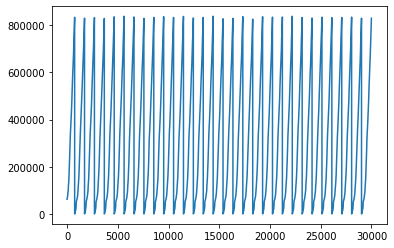

In [32]:
plt.plot(total_rewards[-30000:])

## Testing

In [44]:
test_env = Environment(model,df)
test_acts=[]
test_rewards = []
pobs = test_env.reset()
profits_2 = 0

done = False
while not done:
    Q.eval()
    pact = Q(torch.from_numpy(np.array(pobs, dtype=np.float32).reshape(1, -1)).to(device=device))
    pact = np.argmax(pact.data.cpu())
    test_acts.append(pact.item())
    
    obs, reward, done = test_env.step(pact.numpy())
    test_rewards.append(reward)
    profits_2 += reward
    pobs = obs

test_profits = test_env.profits

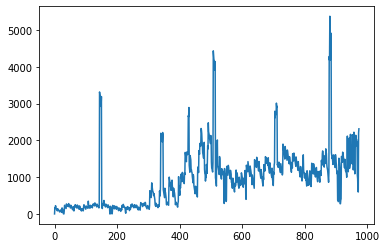

In [45]:
plt.plot(test_rewards)

In [46]:
test_profits

910091.7423867885